In [2]:
import qiskit
import qc_grader
print(f"Qiskit version: {qiskit.__version__}")
print(f"Grader version: {qc_grader.__version__}")

Qiskit version: 2.1.0
Grader version: 0.22.10


In [3]:
your_api_key = "QNUlQWQL_xWIjnr02CxqdlFoshyN94Ib4p1WZI74kKm9"
your_crn = "crn:v1:bluemix:public:quantum-computing:us-east:a/7e46637860994aa8a43e6f360effb216:709c0a5f-fedf-4fc0-a1f6-b6ef1439cef9::"

from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=your_api_key,
    instance=your_crn,
    name="qgss-2025",
    overwrite=True
)

In [4]:
# Check that the account has been saved properly
from qiskit_ibm_runtime import QiskitRuntimeService


service = QiskitRuntimeService(name="qgss-2025")
service.saved_accounts()

{'qgss-2025': {'channel': 'ibm_quantum_platform',
  'url': 'https://cloud.ibm.com',
  'token': 'QNUlQWQL_xWIjnr02CxqdlFoshyN94Ib4p1WZI74kKm9',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/7e46637860994aa8a43e6f360effb216:709c0a5f-fedf-4fc0-a1f6-b6ef1439cef9::',
  'verify': True,
  'private_endpoint': False}}

In [5]:
import rustworkx as rx
import numpy as np
import matplotlib.pyplot as plt
from rustworkx.visualization import mpl_draw as draw_graph
from qiskit_ibm_runtime import QiskitRuntimeService
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix, Operator
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.transpiler import Layout

from qiskit_ibm_runtime import (
    Session,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions,
)
from qiskit_ibm_runtime.debug_tools import Neat
from qiskit_aer import AerSimulator

from utils import zne_method, plot_zne, plot_backend_errors_and_counts
from qc_grader.challenges.qgss_2025 import (
    grade_lab2_ex1,
    grade_lab2_ex2,
    grade_lab2_ex3,
    grade_lab2_ex4,
    grade_lab2_ex5,
    grade_lab2_ex6a,
    grade_lab2_ex6b,
)

In [22]:
# Execute to make arrays of properties
service = QiskitRuntimeService(name="qgss-2025")
# We define a specific backend
brisbane_backend = service.backend("ibm_brisbane")
# We obtain the system properties, number of qubits and coupling map
properties = brisbane_backend.properties()
num_qubits = brisbane_backend.num_qubits
coupling_map = brisbane_backend.coupling_map

# We define various lists of metrics for all the qubits of the backend
t1, t2, gate_error_x, readout_error, gate_error_ecr, pairs = [], [], [], [], [], []
for i in range(num_qubits):
    t1.append(properties.t1(i))
    t2.append(properties.t2(i))
    gate_error_x.append(properties.gate_error(gate="x", qubits=i))
    readout_error.append(properties.readout_error(i))
    print(f"Qubit {i}: T1 = {t1[i]}, T2 = {t2[i]}, gate_error_x = {gate_error_x[i]}, readout_error = {readout_error[i]}")
for pair in coupling_map:
    gate_error_ecr.append(properties.gate_error(gate="ecr", qubits=pair))
    pairs.append(pair)
    print(f"Qubit pair {pair}: gate_error_ecr = {gate_error_ecr[-1]}")

Qubit 0: T1 = 0.0002985979753744162, T2 = 3.4141147304349197e-05, gate_error_x = 0.0005575919499913191, readout_error = 0.039794921875
Qubit 1: T1 = 0.0003027173801625371, T2 = 0.0003425693270764736, gate_error_x = 0.00012198684010996678, readout_error = 0.020263671875
Qubit 2: T1 = 0.0002256091854342486, T2 = 0.00010058821903718927, gate_error_x = 0.0001735414011416654, readout_error = 0.01025390625
Qubit 3: T1 = 0.00032585639613865526, T2 = 0.0003607045550084656, gate_error_x = 0.0001393212864043867, readout_error = 0.031494140625
Qubit 4: T1 = 0.00030695679498646635, T2 = 0.00036472739544538045, gate_error_x = 0.0001246107731497417, readout_error = 0.017578125
Qubit 5: T1 = 0.00022336164694695376, T2 = 0.00017192626592353328, gate_error_x = 0.00015654709087342244, readout_error = 0.01953125
Qubit 6: T1 = 0.00036725098940151705, T2 = 9.236059316179516e-05, gate_error_x = 0.0002260921529151455, readout_error = 0.0107421875
Qubit 7: T1 = 0.00018834921731778284, T2 = 0.00010369520962069

In [25]:
def find_best_metrics(backend: QiskitRuntimeService.backend) -> list[tuple[int or list, float]]:
    """Finds the best-performing qubits and qubit pair based on various hardware metrics."""
    # ---- TODO : Task 1 ---
    # Goal: Obtain the best value and the index or indices of the qubits of the following metrics:
    
    # We obtain the system properties, number of qubits and coupling map
    properties = backend.properties()
    num_qubits = backend.num_qubits
    coupling_map = backend.coupling_map

    # We define various lists of metrics for all the qubits of the backend
    t1, t2, gate_error_x, readout_error, gate_error_ecr, pairs = [], [], [], [], [], []
    for i in range(num_qubits):
        t1.append(properties.t1(i))
        t2.append(properties.t2(i))
        gate_error_x.append(properties.gate_error(gate="x", qubits=i))
        readout_error.append(properties.readout_error(i))
    for pair in coupling_map:
        gate_error_ecr.append(properties.gate_error(gate="ecr", qubits=pair))
        pairs.append(pair)
    #find the best qubit (index_t1_max) with the longest T1 and its value (max_t1)
    index_t1_max = t1.index(max(t1))  # Find the index of the maximum T1 value
    max_t1 = t1[index_t1_max]  # Get the maximum T1 value

    #find the best qubit (index_t2_max) with the longest T2 and its value (max_t2)
    index_t2_max = t2.index(max(t2))  # Find the index of the maximum T2 value
    max_t2 = t2[index_t2_max]  # Get the maximum T2 value

    #find the best qubit (index_min_x_error) with the smallest x gate error and its value (min_x_error)
    index_min_x_error = gate_error_x.index(min(gate_error_x))  # Find the index of the minimum x gate error
    min_x_error = gate_error_x[index_min_x_error]  # Get the minimum x gate error value

    #find the best qubit (index_min_readout) with the smallest readout error and its value (min_readout)
    index_min_readout= readout_error.index(min(readout_error))  # Find the index of the minimum readout error
    min_readout = readout_error[index_min_readout]  # Get the minimum readout error value

    #find the best qubit pairs with minimum ecr error (min_ecr_pair) and its value (min_ecr_error)

    min_ecr_index= gate_error_ecr.index(min(gate_error_ecr))  # Find the index of the minimum ECR error
    # Find the index of the minimum ECR error

    min_ecr_pair = pairs[min_ecr_index] # Get the qubit
    min_ecr_error = gate_error_ecr[min_ecr_index]   # Get the minimum ECR error value
    
    # --- End of TODO ---

    solutions = [
        [int(index_t1_max), max_t1],
        [int(index_t2_max), max_t2],
        [int(index_min_x_error), min_x_error],
        [int(index_min_readout), min_readout],
        [list(min_ecr_pair), min_ecr_error],
    ]
    print("Solutions:")
    for solution in solutions:
        print(solution)
    return solutions

In [26]:
# Submit your answer using the following code
grade_lab2_ex1(find_best_metrics)

Solutions:
[23, 0.0004251690149981477]
[17, 0.000411526589586579]
[10, 8.870440259419917e-05]
[112, 0.005615234375]
[[12, 17], 0.003657137378589581]
Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


# Ex 2

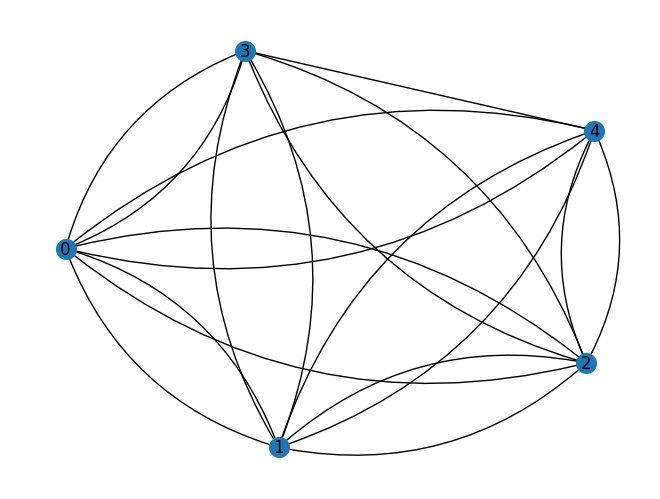

In [90]:
# We define the seed
seed = 43
# We define the number of nodes:
n = 5
# We define the graph
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
generic_backend = GenericBackendV2(n, seed=seed)
weights = 1
# We make it explicitly asymmetrical to have a smaller set of solutions
graph.add_edges_from([(edge[0], edge[1], weights) for edge in generic_backend.coupling_map][:-1])
draw_graph(graph, node_size=200, with_labels=True, width=1)

In [96]:
def graph_to_Pauli(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list."""
    
    pauli_list = []
    initial_pauli = "I" * graph.num_nodes()  # Initialize a string of 'I's for each node

   # Use a dictionary to accumulate weights for each unique Pauli word
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"
 
        weight = graph.get_edge_data(edge[0], edge[1])
 
        pauli_list.append(("".join(paulis)[::-1], weight))

        
    # ---- TODO : Task 2 ---
    # Goal: Convert the graph into a list like: [['PauliWord_1', weight_1], ['PauliWord_2', weight_2],...]

    # --- End of TODO ---

    return pauli_list


max_cut_paulis = graph_to_Pauli(graph)
cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIIZZ', 'IIZIZ', 'IIZIZ', 'IZIIZ', 'IZIIZ', 'ZIIIZ', 'ZIIIZ', 'IIZZI', 'IIZZI', 'IZIZI', 'IZIZI', 'ZIIZI', 'ZIIZI', 'IZZII', 'IZZII', 'ZIZII', 'ZIZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j])


In [97]:
# Submit your answer using the following code
grade_lab2_ex2(graph_to_Pauli)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


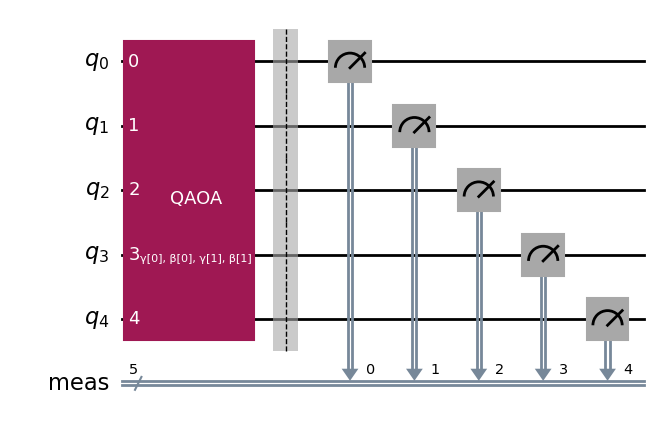

In [98]:
layers = 2
qaoa_circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=layers)
qaoa_circuit.measure_all()
qaoa_circuit.draw("mpl")

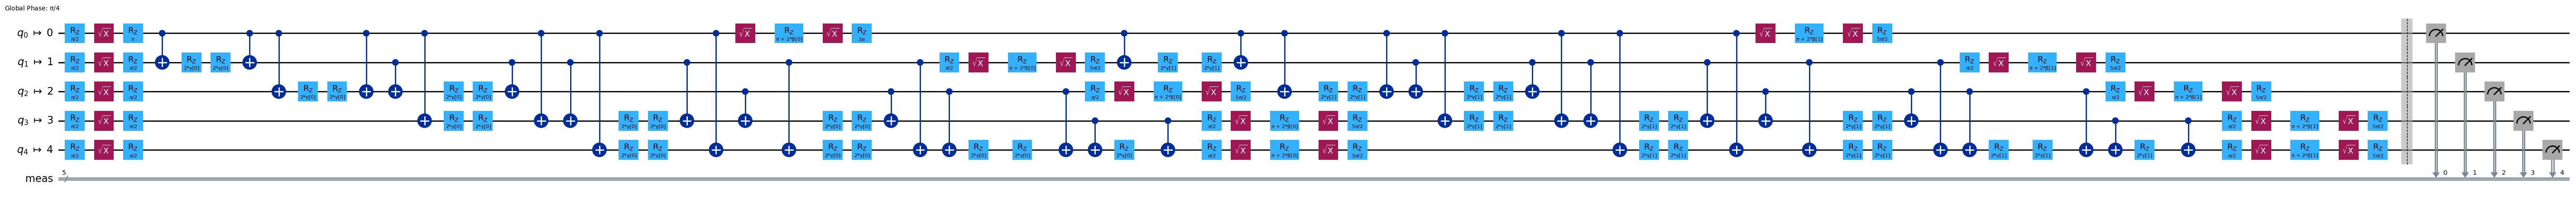

In [99]:
# Create pass manager for transpilation

pm = generate_preset_pass_manager(
    optimization_level=3, backend=generic_backend, seed_transpiler=seed
)

qaoa_circuit_transpiled = pm.run(qaoa_circuit)
qaoa_circuit_transpiled.draw("mpl", fold=False, idle_wires=False)

In [100]:
init_params = np.zeros(2 * layers)

In [101]:
objective_func_vals = []


def cost_func_estimator(
    params: list, ansatz: QuantumCircuit, isa_hamiltonian: SparsePauliOp, estimator: Estimator
) -> float:
    """Compute the cost function value using a parameterized ansatz and an estimator for a given Hamiltonian."""
    if isa_hamiltonian.num_qubits != ansatz.num_qubits:
        isa_hamiltonian = isa_hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    objective_func_vals.append(cost)
    return cost


def train_qaoa(
    params: list,
    circuit: QuantumCircuit,
    hamiltonian: SparsePauliOp,
    backend: QiskitRuntimeService.backend,
) -> tuple:
    """Optimize QAOA parameters using COBYLA and an estimator on a given backend."""
    with Session(backend=backend) as session:
        options = {"simulator": {"seed_simulator": seed}}
        estimator = Estimator(mode=session, options=options)
        estimator.options.default_shots = 100000

        result = minimize(
            cost_func_estimator,
            params,
            args=(circuit, hamiltonian, estimator),
            method="COBYLA",
            options={"maxiter": 200, "rhobeg": 1, "catol": 1e-3, "tol": 0.0001},
        )
    print(result)
    return result, objective_func_vals


result_qaoa, objective_func_vals = train_qaoa(
    init_params, qaoa_circuit_transpiled, cost_hamiltonian, generic_backend
)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -3.2863771362286376
       x: [ 9.958e-01  1.181e+00  3.710e-02  9.495e-01]
    nfev: 47
   maxcv: 0.0


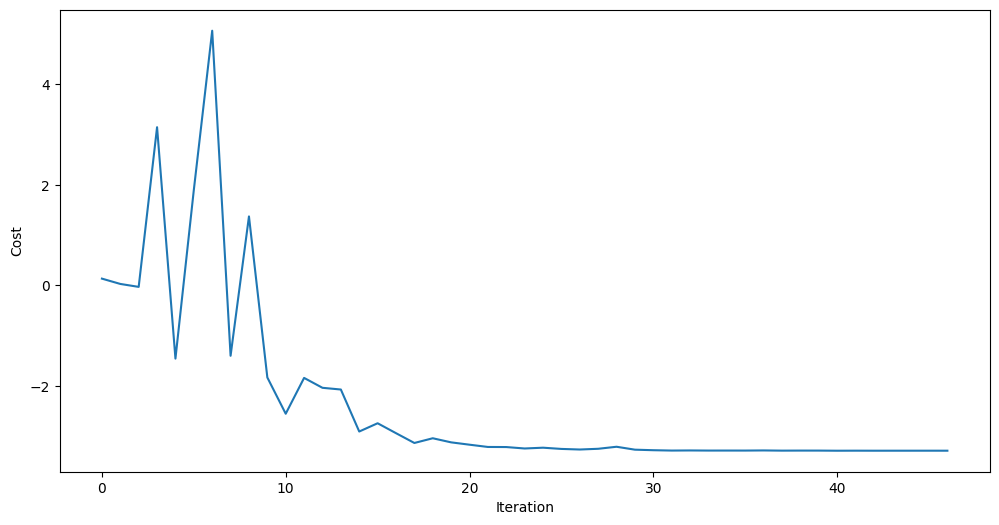

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

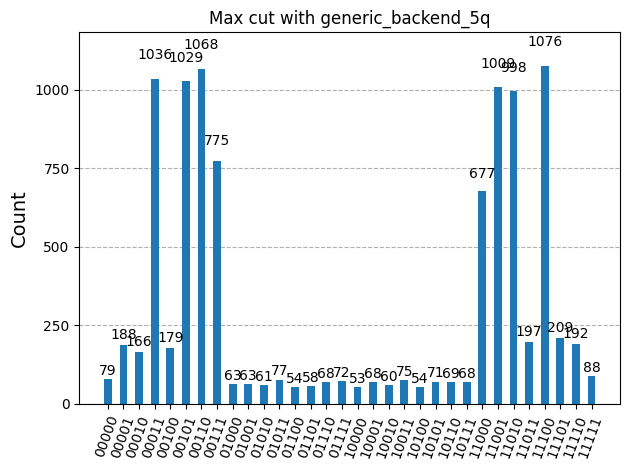

In [103]:
# Get the optimized parameters from the result
opt_params = result_qaoa.x
SHOTS = 10000


def sample_qaoa(opt_params, circuit, backend):

    # Submit the circuit to Sampler
    options = {"simulator": {"seed_simulator": seed}}
    sampler = Sampler(mode=backend, options=options)
    job = sampler.run([(circuit, opt_params)], shots=SHOTS)
    results_sampler = job.result()
    counts_list = results_sampler[0].data.meas.get_counts()
    display(plot_histogram(counts_list, title=f"Max cut with {backend.name}"))

    return counts_list


counts_list = sample_qaoa(opt_params, qaoa_circuit_transpiled, generic_backend)


In [105]:
eigenvalues, eigenvectors = np.linalg.eig(cost_hamiltonian)
ground_energy = min(eigenvalues).real
num_solutions = eigenvalues.tolist().count(ground_energy)
index_solutions = np.where(eigenvalues == ground_energy)[0].tolist()
print(f"The ground energy of the Hamiltonian is {ground_energy}")
print(f"The number of solutions of the problem is {num_solutions}")
print(f"The list of the solutions based on their index is {index_solutions}")

The ground energy of the Hamiltonian is -5.0
The number of solutions of the problem is 8
The list of the solutions based on their index is [3, 5, 6, 7, 24, 25, 26, 28]


In [106]:
def decimal_to_binary(decimal_list, n):
    return [bin(num)[2:].zfill(n) for num in decimal_list]


# Convert the solutions to quantum states
states_solutions = decimal_to_binary(index_solutions, n)
# Sort the dictionary items by their counts in descending order
sorted_states = sorted(counts_list.items(), key=lambda item: item[1], reverse=True)
# Take the top 'num_solutions' entries
top_states = sorted_states[:num_solutions]
# Extract only the states keys from the top entries
qaoa_ground_states = sorted([state for state, count in top_states])
print(f"The analytical solutions for the Max-cut problem are: {states_solutions}")
print(f"The QAOA ground states solutions for the Max-cut are: {qaoa_ground_states}")

The analytical solutions for the Max-cut problem are: ['00011', '00101', '00110', '00111', '11000', '11001', '11010', '11100']
The QAOA ground states solutions for the Max-cut are: ['00011', '00101', '00110', '00111', '11000', '11001', '11010', '11100']


In [ ]:
# Ex 3


In [107]:
real_backends = service.backends()
print(f"The quantum computers available for you are {real_backends}")

The quantum computers available for you are [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_torino')>]


In [108]:
# backends=[service.backend("alt_brisbane"),service.backend("alt_kawasaki"),service.backend("alt_torino")]
real_backends = [
    service.backend("ibm_brisbane"),
    service.backend("ibm_sherbrooke"),
    service.backend("ibm_torino"),
]

In [109]:
noisy_fake_backends = []
for backend in real_backends:
    noisy_fake_backends.append(AerSimulator.from_backend(backend, seed_simulator=seed))
print(f"The noisy simulators are {noisy_fake_backends}")

The noisy simulators are [AerSimulator('aer_simulator_from(ibm_brisbane)'
             noise_model=<NoiseModel on ['reset', 'x', 'ecr', 'measure', 'sx', 'id']>), AerSimulator('aer_simulator_from(ibm_sherbrooke)'
             noise_model=<NoiseModel on ['reset', 'x', 'ecr', 'measure', 'sx', 'id']>), AerSimulator('aer_simulator_from(ibm_torino)'
             noise_model=<NoiseModel on ['reset', 'x', 'measure', 'sx', 'cz', 'id']>)]


In [120]:
# Define a function that calculates the accumulated total errors of single and two qubit gates and readout


def accumulated_errors(backend: QiskitRuntimeService.backend, circuit: QuantumCircuit) -> list:
    """Compute accumulated gate and readout errors for a given circuit on a specific backend."""
    acc_single_qubit_error = 0
    acc_two_qubit_error = 0
    single_qubit_gate_count = 0
    two_qubit_gate_count = 0
    acc_readout_error = 0

    # Get backend properties
    properties = backend.properties()
    config = backend.configuration()

    # Determine two-qubit gate type
    if "ecr" in config.basis_gates:
        two_qubit_gate = "ecr"
    elif "cz" in config.basis_gates:
        two_qubit_gate = "cz"
    else:
        two_qubit_gate = None

    # Readout errors: sum for all measured qubits
    measured_qubits = set(circuit.qubits.index(q) for instr, qargs, _ in circuit.data if instr.name == 'measure' for q in qargs)
    for q in measured_qubits:
        acc_readout_error += properties.readout_error(q)

    # Loop over instructions
    for instr, qargs, _ in circuit.data:
        qubits = [circuit.qubits.index(q) for q in qargs]
        name = instr.name

        if len(qubits) == 1 and name in config.basis_gates:
            single_qubit_gate_count += 1
            gate_props = properties.gate_error(name, [qubits[0]])
            acc_single_qubit_error += gate_props
        elif len(qubits) == 2 and name == two_qubit_gate:
            two_qubit_gate_count += 1
            gate_props = properties.gate_error(name, qubits)
            acc_two_qubit_error += gate_props

    acc_total_error = acc_single_qubit_error + acc_two_qubit_error + acc_readout_error

    return [
        acc_total_error,
        acc_two_qubit_error,
        acc_single_qubit_error,
        acc_readout_error,
        single_qubit_gate_count,
        two_qubit_gate_count
    ]

In [121]:
qaoa_transpiled_list = []
errors_and_counts_list = []
for noisy_fake_backend in noisy_fake_backends:
    pm = generate_preset_pass_manager(
        backend=noisy_fake_backend,
        optimization_level=3,
        seed_transpiler=seed,
    )
    circuit = pm.run(qaoa_circuit)
    qaoa_transpiled_list.append(circuit)

    errors_and_counts = accumulated_errors(noisy_fake_backend, circuit)
    errors_and_counts_list.append(errors_and_counts)
# You can print your results to visualize if they are correct
for backend, (
    acc_total_error,
    acc_two_qubit_error,
    acc_single_qubit_error,
    acc_readout_error,
    single_qubit_gate_count,
    two_qubit_gate_count,
) in zip(noisy_fake_backends, errors_and_counts_list):
    print(f"Backend {backend.name}")
    print(f"Accumulated two-qubit error of {two_qubit_gate_count} gates: {acc_two_qubit_error:.3f}")
    print(
        f"Accumulated one-qubit error of {single_qubit_gate_count} gates: {acc_single_qubit_error:.3f}"
    )
    print(f"Accumulated readout error: {acc_readout_error:.3f}")
    print(f"Accumulated total error: {acc_total_error:.3f}\n")

Backend aer_simulator_from(ibm_brisbane)
Accumulated two-qubit error of 70 gates: 0.222
Accumulated one-qubit error of 457 gates: 0.023
Accumulated readout error: 0.108
Accumulated total error: 0.353

Backend aer_simulator_from(ibm_sherbrooke)
Accumulated two-qubit error of 70 gates: 0.224
Accumulated one-qubit error of 442 gates: 0.026
Accumulated readout error: 0.118
Accumulated total error: 0.367

Backend aer_simulator_from(ibm_torino)
Accumulated two-qubit error of 70 gates: 0.138
Accumulated one-qubit error of 250 gates: 0.030
Accumulated readout error: 0.107
Accumulated total error: 0.274



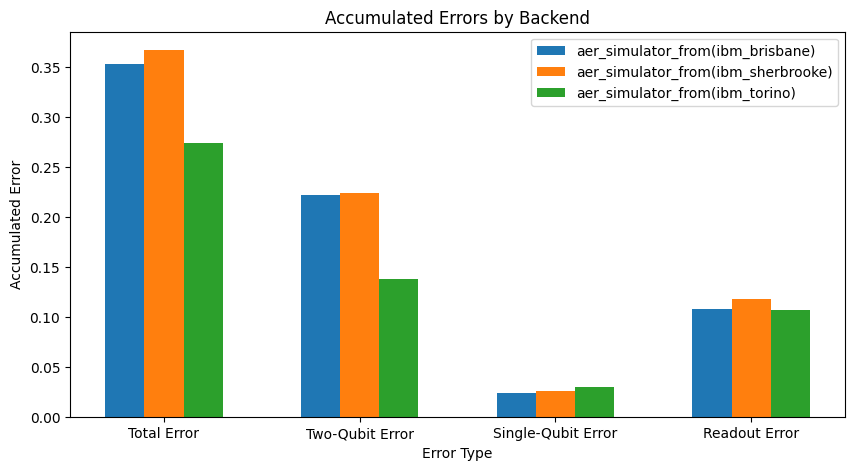

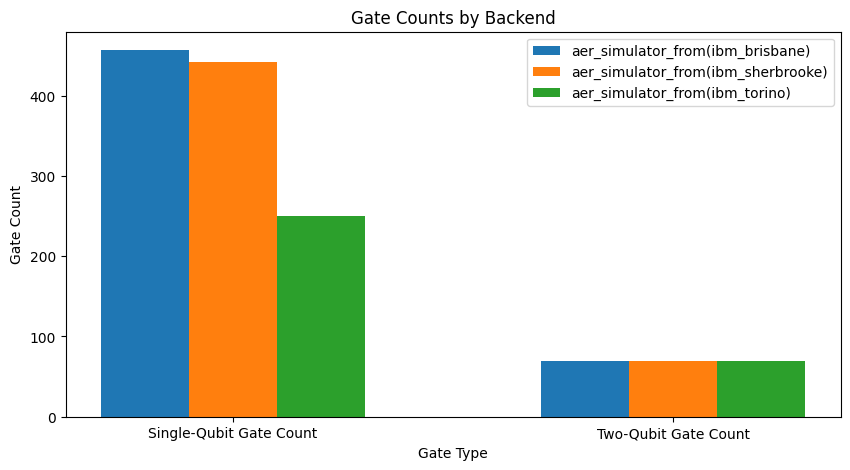

In [122]:
plot_backend_errors_and_counts(noisy_fake_backends, errors_and_counts_list)

In [123]:
# Submit your answer using the following code
grade_lab2_ex3(accumulated_errors)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -2.848961510384896
       x: [ 1.007e+00  1.216e+00  3.659e-02  9.599e-01]
    nfev: 62
   maxcv: 0.0


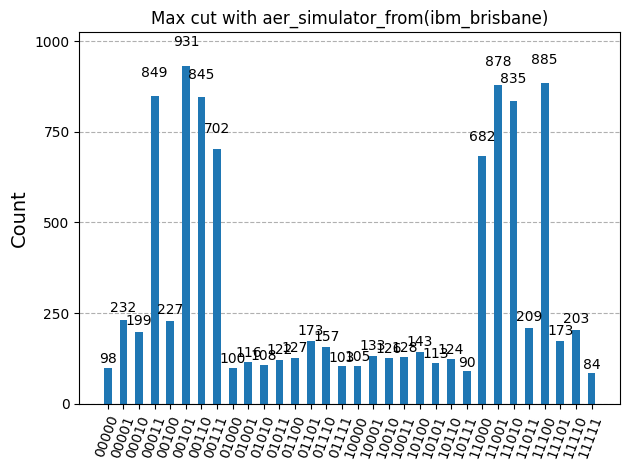

In [124]:
opt_params_list = []
counts_list_backends = []
for noisy_fake_backend, circuit in zip(noisy_fake_backends[:1], qaoa_transpiled_list[:1]):
    result_backend, _ = train_qaoa(init_params, circuit, cost_hamiltonian, noisy_fake_backend)
    opt_params = result_backend.x
    opt_params_list.append(opt_params)
    counts_list_backend = sample_qaoa(opt_params, circuit, noisy_fake_backend)
    counts_list_backends.append(counts_list_backend)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -2.9459005409945904
       x: [ 1.079e+00  1.255e+00  4.797e-02  9.740e-01]
    nfev: 97
   maxcv: 0.0


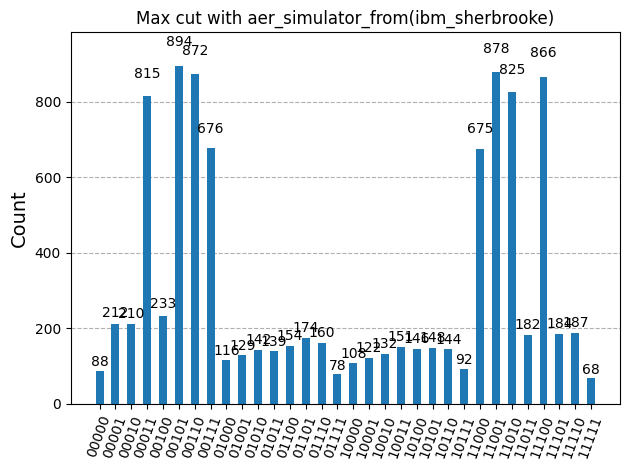

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -3.8814911850881493
       x: [ 1.119e+00 -2.168e-01  8.856e-01  9.612e-01]
    nfev: 75
   maxcv: 0.0


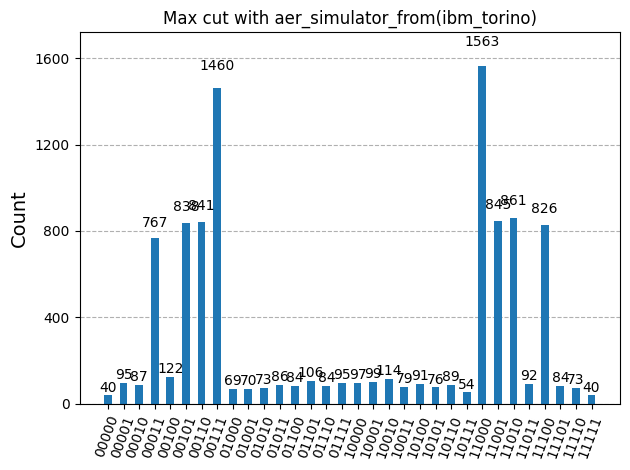

In [125]:
for noisy_fake_backend, circuit in zip(noisy_fake_backends[1:], qaoa_transpiled_list[1:]):
    result_backend, _ = train_qaoa(init_params, circuit, cost_hamiltonian, noisy_fake_backend)
    opt_params = result_backend.x
    opt_params_list.append(opt_params)
    counts_list_backend = sample_qaoa(opt_params, circuit, noisy_fake_backend)
    counts_list_backends.append(counts_list_backend)

In [126]:
for noisy_fake_backend, counts_list_backend in zip(noisy_fake_backends, counts_list_backends):
    solutions_counts = [counts_list_backend[key] for key in states_solutions]
    print(
        f"Probability of measuring a solution for {noisy_fake_backend.name} is {float(sum(solutions_counts)/SHOTS)}"
    )

Probability of measuring a solution for aer_simulator_from(ibm_brisbane) is 0.6607
Probability of measuring a solution for aer_simulator_from(ibm_sherbrooke) is 0.6501
Probability of measuring a solution for aer_simulator_from(ibm_torino) is 0.8001


In [127]:
solutions_counts_noiseless = [counts_list[key] for key in states_solutions]
print(
    f"Probability of measuring a solution for {generic_backend.name} is {float(sum(solutions_counts_noiseless)/SHOTS)}"
)

Probability of measuring a solution for generic_backend_5q is 0.7668


In [128]:
results = []
for backend, opt_params in zip(noisy_fake_backends, opt_params_list):
    print(f"\nRunning on backend: {backend.name}")

    # Prepare the QAOA circuit with optimized parameters
    qaoa_neat = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=layers)
    qc = qaoa_neat.assign_parameters(opt_params)

    # Transpile the circuit
    qc_transpiled = generate_preset_pass_manager(
        optimization_level=3,
        basis_gates=backend.configuration().basis_gates[:n],
        seed_transpiler=seed,
    ).run(qc)
    # Use cost Hamiltonian as observable for Cliffordization
    obs = cost_hamiltonian
    analyzer = Neat(backend)
    clifford_pub = analyzer.to_clifford([(qc_transpiled, obs)])[0]

    # Construct observable from Clifford circuit
    state_clifford = Statevector.from_instruction(clifford_pub.circuit)
    obs_clifford = SparsePauliOp.from_operator(Operator(DensityMatrix(state_clifford).data))

    # Apply layout
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=seed)
    isa_qc = pm.run(clifford_pub.circuit)
    isa_obs = obs_clifford.apply_layout(isa_qc.layout)

    # Prepare pubs and simulate
    pubs = [(isa_qc, isa_obs)]
    result_noiseless = (
        analyzer.ideal_sim(pubs, cliffordize=True, seed_simulator=seed)._pub_results[0].vals
    )
    noisy_results = (
        analyzer.noisy_sim(pubs, cliffordize=True, seed_simulator=seed)._pub_results[0].vals
    )

    # Store and print results
    results.append({"backend": backend.name, "noiseless": result_noiseless, "noisy": noisy_results})
    print(f"Ideal results on {backend.name}:\n{result_noiseless:.3f}")
    print(f"Noisy results on {backend.name}:\n{noisy_results:.3f}")


Running on backend: aer_simulator_from(ibm_brisbane)
Ideal results on aer_simulator_from(ibm_brisbane):
1.000
Noisy results on aer_simulator_from(ibm_brisbane):
0.770

Running on backend: aer_simulator_from(ibm_sherbrooke)
Ideal results on aer_simulator_from(ibm_sherbrooke):
1.000
Noisy results on aer_simulator_from(ibm_sherbrooke):
0.689

Running on backend: aer_simulator_from(ibm_torino)
Ideal results on aer_simulator_from(ibm_torino):
1.000
Noisy results on aer_simulator_from(ibm_torino):
0.792


# ex 4

In [129]:
# We select the `ibm_brisbane` backend
num_backend = 0
noisy_fake_backend = noisy_fake_backends[num_backend]

pm = generate_preset_pass_manager(
    backend=noisy_fake_backend,
    optimization_level=3,
    seed_transpiler=seed,
    layout_method="sabre",
)
circuit_transpiled = pm.run(qaoa_circuit)


def two_qubit_gate_errors_per_circuit_layout(
    circuit: QuantumCircuit, backend: QiskitRuntimeService.backend
) -> tuple:
    """Calculate accumulated two-qubit gate errors and related metrics for a given circuit layout."""
    pair_list = []
    error_pair_list = []
    error_acc_pair_list = []
    two_qubit_gate_count = 0
    properties = backend.properties()
    if "ecr" in (backend.configuration().basis_gates):
        two_qubit_gate = "ecr"
    elif "cz" in (backend.configuration().basis_gates):
        two_qubit_gate = "cz"
    for instruction in circuit.data:
        if instruction.operation.num_qubits == 2:
            two_qubit_gate_count += 1
            pair = [instruction.qubits[0]._index, instruction.qubits[1]._index]
            error_pair = properties.gate_error(gate=two_qubit_gate, qubits=pair)
            if pair not in (pair_list):
                pair_list.append(pair)
                error_pair_list.append(error_pair)
                error_acc_pair_list.append(error_pair)
            else:
                pos = pair_list.index(pair)
                error_acc_pair_list[pos] += error_pair

    acc_two_qubit_error = sum(error_acc_pair_list)
    return (
        acc_two_qubit_error,
        two_qubit_gate_count,
        pair_list,
        error_pair_list,
        error_acc_pair_list,
    )


(
    acc_two_qubit_error,
    two_qubit_gate_count,
    pair_list,
    error_pair_list,
    error_acc_pair_list,
) = two_qubit_gate_errors_per_circuit_layout(circuit_transpiled, noisy_fake_backend)
two_qubit_ops_list = [int(a / b) for a, b in zip(error_acc_pair_list, error_pair_list)]
# We print the results
print(f"The pairs of qubits that need to perform two-qubit operations are:\n {pair_list}")
print(
    f"The errors introduced by each of the two-qubit operations are:\n {[round(err,3) for err in error_pair_list]}"
)
print(
    f"The accumulated errors introduced by each of the two-qubit operations are:\n {[round(err,3) for err in error_acc_pair_list]}"
)
print(f"The repetitions of each one of the two-qubit operations is:\n {two_qubit_ops_list}")
print(f"The number of two-qubit operations in total:\n {two_qubit_gate_count}")
print(f"The total accumulated error by two-qubit operations is:\n {acc_two_qubit_error:.3f}")

The pairs of qubits that need to perform two-qubit operations are:
 [[62, 72], [81, 72], [62, 61], [62, 63]]
The errors introduced by each of the two-qubit operations are:
 [0.009, 0.005, 0.014, 0.007]
The accumulated errors introduced by each of the two-qubit operations are:
 [0.275, 0.06, 0.18, 0.107]
The repetitions of each one of the two-qubit operations is:
 [29, 13, 13, 15]
The number of two-qubit operations in total:
 70
The total accumulated error by two-qubit operations is:
 0.622


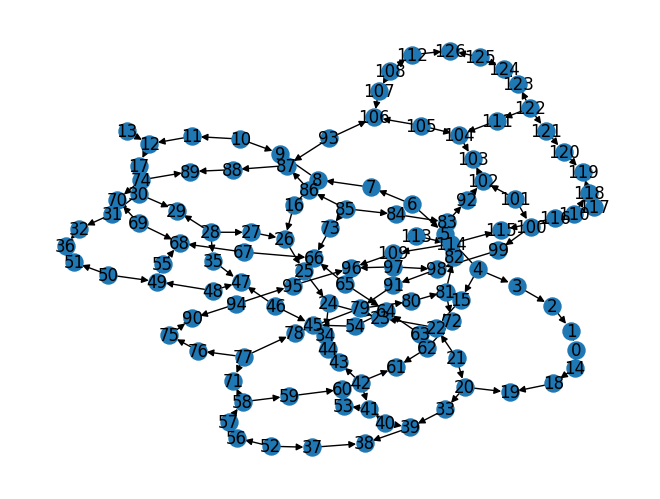

In [130]:
# We build a graph with the connectivity constraints of our backend that includes the two-qubit gate errors as weights in the edges
graph = rx.PyDiGraph()
graph.add_nodes_from(np.arange(0, noisy_fake_backend.num_qubits, 1))
two_qubit_gate = "ecr"
graph.add_edges_from(
    [
        (
            edge[0],
            edge[1],
            noisy_fake_backend.properties().gate_error(
                gate=two_qubit_gate, qubits=(edge[0], edge[1])
            ),
        )
        for edge in noisy_fake_backend.coupling_map
    ]
)
draw_graph(graph, node_size=150, with_labels=True, width=1)

In [131]:
def remap_nodes(original_labels: list, edge_list: list[list]) -> list[list[int]]:
    """Remap node labels to a new sequence starting from 0 based on their order in original_labels."""
    label_mapping = {label: idx for idx, label in enumerate(original_labels)}
    remapped = [[label_mapping[src], label_mapping[dst]] for src, dst in edge_list]
    return remapped


layout_list = list(circuit_transpiled.layout.initial_layout.get_physical_bits().keys())[:5]
logical_pair_list = remap_nodes(layout_list, pair_list)
print(f"Physical qubit layout list:\n {layout_list}")
print(f"\nOriginal two-qubit gates list:\n {pair_list}")
print(f"\nRemapped two-qubit gates list (in logical qubits):\n {logical_pair_list}")

Physical qubit layout list:
 [72, 62, 81, 61, 63]

Original two-qubit gates list:
 [[62, 72], [81, 72], [62, 61], [62, 63]]

Remapped two-qubit gates list (in logical qubits):
 [[1, 0], [2, 0], [1, 3], [1, 4]]


In [132]:
def find_paths_with_weight_sum_below_threshold(
    graph: rx.PyDiGraph,
    threshold: float,
    two_qubit_ops_list: list[int],
    logical_pair_list: list[list[int]],
) -> tuple[list[list[int]], list[float]]:
    """Find all valid paths through a graph whose weighted sum is below a given threshold."""
    valid_paths = []
    valid_weights = []

    # Task 4 ---
    # Goal: Find all valid paths through a graph such that the total weighted sum of the path is below a given threshold.

    # Iterate over all possible starting nodes in the graph
    for start_node in range(graph.num_nodes()):
        # Initialize the list of paths with a single-node path starting from the current node
        paths = [[start_node]]
        # Initialize the corresponding weights for each path (starting with 0)
        weights = [0]
        # Iterate through each step in the sequence of two-qubit operations
        for i in range(len(two_qubit_ops_list)):
            new_paths = []    
            new_weights = []  
            # Go through each current path and its weight
            for path, weight in zip(paths, weights):
                # We need to determine which node in the current path is involved in the next logical operation, so we can expand from it.
                # Determine which node in the path we are going to expand from using logical_pair_list
                if logical_pair_list[i][0] < logical_pair_list[i][1]:
                    index_of_expanding_node = logical_pair_list[i][0] # control qubit
                    node_to_expand_from = path[index_of_expanding_node]
                    # Explore all neighbors of the node_to_expand_from
                    for neighbor in graph.neighbors(node_to_expand_from):
                        # Ensure we don't revisit nodes and the edge exists
                        if neighbor not in path and graph.has_edge(node_to_expand_from, neighbor):
                            # Calculate the edge weight, scaled by the number of times the gate is applied which is in two_qubit_ops_list
                            
                            #### TODO ####
                            
                            edge_weight = two_qubit_ops_list[i] * graph.get_edge_data(node_to_expand_from, neighbor)
                            
                            #### End of TODO ####
                            
                            # Extend the path and update the weight
                            new_paths.append(path + [neighbor])
                            new_weights.append(weight + edge_weight)
                else:
                    index_of_expanding_node = logical_pair_list[i][1] # target qubit
                    node_to_expand_from = path[index_of_expanding_node]
                    # Explore all undirected_neighbors of the node_to_expand_from
                    for neighbor in graph.neighbors_undirected(node_to_expand_from):
                        # Ensure we don't revisit nodes and the edge exists
                        if neighbor not in path and graph.has_edge(neighbor, node_to_expand_from):
                            # Calculate the edge weight, scaled by the number of times the gate is applied which is in two_qubit_ops_list
                            
                            #### TODO ####
                            
                            edge_weight = two_qubit_ops_list[i] * graph.get_edge_data(neighbor, node_to_expand_from)
                            
                            #### End of TODO ####
                            
                            # Extend the path and update the weight
                            new_paths.append(path + [neighbor])
                            new_weights.append(weight + edge_weight)
            # Update paths and weights for the next iteration
            paths = new_paths
            weights = new_weights

        # After building all possible paths, filter those under the threshold
        for path, weight in zip(paths, weights):

            #### TODO: Complete the condition for `if` ####
            
            if (weight < threshold): 
                valid_paths.append(path)
                valid_weights.append(weight)

            #### End of TODO ####
            
    # --- End of TODO ---

    return valid_paths, valid_weights


threshold = acc_two_qubit_error

valid_paths, valid_weights = find_paths_with_weight_sum_below_threshold(
    graph, threshold, two_qubit_ops_list, logical_pair_list
)
# Note that there could be no other paths with smaller errors
if valid_weights:
    minimum_weight_index = valid_weights.index(min(valid_weights))
    opt_layout = valid_paths[minimum_weight_index]
else:
    minimum_weight_index = None
    opt_layout = layout_list
print(f"We found {len(valid_paths)} valid paths")

We found 10 valid paths


In [135]:
	
init_layout = Layout({q: phys for q, phys in zip(qaoa_circuit.qubits, opt_layout)})
pm = generate_preset_pass_manager(
    backend=noisy_fake_backend,
    optimization_level=3,
    seed_transpiler=seed,
    initial_layout=init_layout,
    layout_method="sabre",
)

circuit_opt = pm.run(qaoa_circuit)

(
    acc_total_error_opt,
    two_qubit_gate_count,
    pair_list,
    error_pair_list,
    error_acc_pair_list,
) = two_qubit_gate_errors_per_circuit_layout(circuit_opt, noisy_fake_backend)

print(
    f"The path with smaller errors in its two-qubit gates is: {opt_layout} \n",
    f"With total accumulated error of {acc_total_error_opt:.3f}",
)

The path with smaller errors in its two-qubit gates is: [5, 4, 6, 15, 3] 
 With total accumulated error of 0.271


In [136]:
# Submit your answer using the following code
grade_lab2_ex4(find_paths_with_weight_sum_below_threshold)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [138]:
def finding_best_seed(
    circuit: QuantumCircuit, backend: QiskitRuntimeService.backend
) -> tuple[QuantumCircuit, int, float, int]:
    """Find the transpiler seed that minimizes two-qubit gate error for a given circuit and backend."""

    # We initialize the minimum error accumulated
    min_err_acc_seed_loop = 100
    circuit_opt_best_seed = None
    # First we loop over 500 seeds and transpile the circuit
    for seed_transpiler in range(0, 500):
        pm = generate_preset_pass_manager(
            backend=backend,
            optimization_level=3,
            seed_transpiler=seed_transpiler,
            layout_method="sabre",
        )
        circuit_opt_seed = pm.run([circuit])[0]
        # ---- TODO : Task 5 ---
        # Goal: Find the transpiler seed that minimizes two-qubit gate error for a given circuit and backend looping from 0 to 500

        # Use the `two_qubit_gate_errors_per_circuit_layout` function to count for the error of the transpiled circuit
        err_acc_seed_loop, two_qubit_gate_count_seed_loop, *_ = two_qubit_gate_errors_per_circuit_layout(
            circuit_opt_seed, backend
        )

        # Check if the error accounted above is smaller than min_err_acc_seed_loop. If so, assign the variables that this function returns
        if err_acc_seed_loop < min_err_acc_seed_loop:
            min_err_acc_seed_loop = err_acc_seed_loop
            circuit_opt_best_seed = circuit_opt_seed
            best_seed_transpiler = seed_transpiler

        # --- End of TODO ---

    return (
        circuit_opt_best_seed,
        best_seed_transpiler,
        min_err_acc_seed_loop,
        two_qubit_gate_count_seed_loop,
    )

In [139]:
(
    circuit_opt_seed_loop,
    best_seed_transpiler,
    min_err_acc_seed_loop,
    two_qubit_gate_count_seed_loop,
) = finding_best_seed(qaoa_circuit, noisy_fake_backend)

best_layout = list(circuit_opt_seed_loop.layout.initial_layout.get_physical_bits().keys())[:n]
print(f"Best transpiler seed: {best_seed_transpiler}")
print(f"Minimum accumulated two-qubit gate error: {min_err_acc_seed_loop:.3f}")
print(f"Two-qubit gate count for best seed: {two_qubit_gate_count_seed_loop}")
print(f"Best layout (first n logical qubits mapped to physical qubits):\n {best_layout}")

Best transpiler seed: 91
Minimum accumulated two-qubit gate error: 0.239
Two-qubit gate count for best seed: 70
Best layout (first n logical qubits mapped to physical qubits):
 [15, 4, 22, 5, 3]


In [140]:
# Submit your answer using the following code
grade_lab2_ex5(finding_best_seed)


Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -2.2859671403285966
       x: [ 5.134e-01  6.299e-01  9.472e-01 -5.009e-02]
    nfev: 64
   maxcv: 0.0


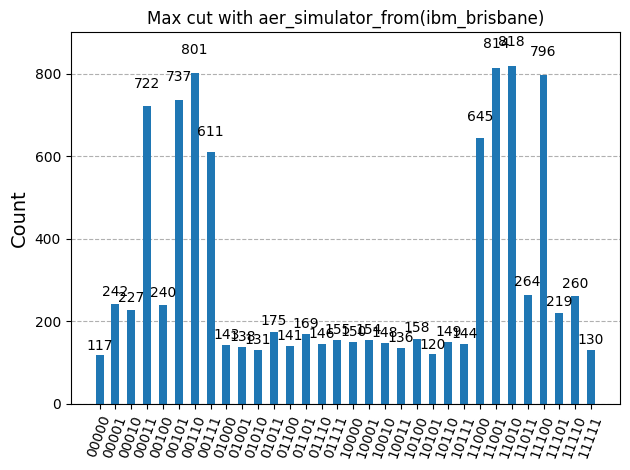

Probability of measuring a solution for is 0.5944
 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -2.3176068239317607
       x: [-3.260e-01 -9.232e-01 -4.950e-01 -7.007e-01]
    nfev: 153
   maxcv: 0.0


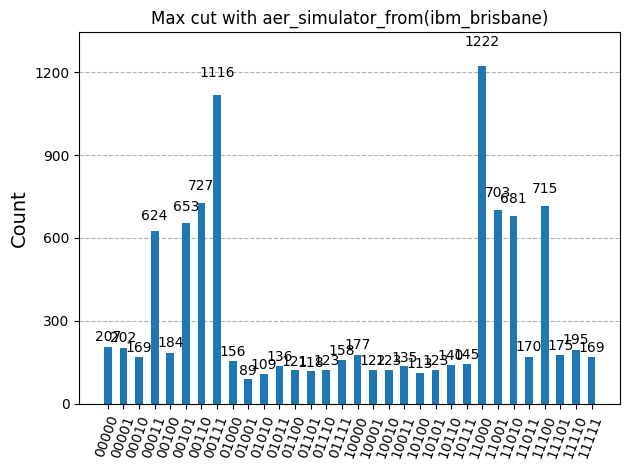

Probability of measuring a solution for is 0.6441


In [141]:
counts_list_transpiled_circuits = []
circuit_transpiled_list = [circuit_transpiled, circuit_opt_seed_loop]
opt_params_list_transpiled_circuits = []
for circuit in circuit_transpiled_list:
    result_backend, _ = train_qaoa(init_params, circuit, cost_hamiltonian, noisy_fake_backend)
    opt_params = result_backend.x
    opt_params_list_transpiled_circuits.append(opt_params)
    counts_list_transpiled_circuit = sample_qaoa(opt_params, circuit, noisy_fake_backend)
    counts_list_transpiled_circuits.append(counts_list_transpiled_circuits)
    solutions_counts = [counts_list_transpiled_circuit[key] for key in states_solutions]
    print(f"Probability of measuring a solution for is {float(sum(solutions_counts)/SHOTS)}")


# Ex 5


In [194]:
def fold_global_circuit(circuit: QuantumCircuit, scale_factor: int) -> QuantumCircuit:
    """Apply global circuit folding for Zero Noise Extrapolation (ZNE)."""
    if scale_factor % 2 == 0 or scale_factor < 1:
        raise ValueError("scale_factor must be an odd positive integer (1, 3, 5, ...)")

    n_repeat = (scale_factor - 1) // 2
    folded_circuit = QuantumCircuit(circuit.qubits, circuit.clbits)

    def remove_all_measurements(qc: QuantumCircuit) -> QuantumCircuit:
        """Remove all measurements from a quantum circuit."""
        clean_qc = QuantumCircuit(qc.num_qubits)
        for instr in qc.data:
            if instr.operation.name != "measure":
                clean_qc.append(instr.operation, instr.qubits)
        return clean_qc

    # Separate measurements so we can reapply them at the end
    clean_circuit = remove_all_measurements(circuit)

    # Add the original unitary once
    folded_circuit.append(clean_circuit, folded_circuit.qubits)

    # Apply (U * U† * U) folding n_repeat times
    for _ in range(n_repeat):
        folded_circuit.append(clean_circuit.inverse(),folded_circuit.qubits)
        folded_circuit.append(clean_circuit,folded_circuit.qubits)


    return folded_circuit

In [195]:
# Submit your answer using the following code
grade_lab2_ex6a(fold_global_circuit)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [198]:
def fold_local_circuit(circuit: QuantumCircuit, scale_factor: int) -> QuantumCircuit:
    """Performs Zero-Noise Folding at the level of individual circuit instructions."""
    if scale_factor % 2 == 0 or scale_factor < 1:
        raise ValueError("scale_factor must be an odd positive integer (1, 3, 5, ...)")
    
    n_repeat = (scale_factor - 1) // 2
    qc_folded = QuantumCircuit(circuit.qubits, circuit.clbits)

    for instrction in circuit.data:
        if instrction.operation.name != "measure":
            # Append the instruction once
            qc_folded.append(instrction.operation, instrction.qubits, instrction.clbits)

            # Apply (U† * U) folding n_repeat times
            for _ in range(n_repeat):
                qc_folded.append(instrction.operation.inverse(), instrction.qubits, instrction.clbits)
                qc_folded.append(instrction.operation, instrction.qubits, instrction.clbits)
        else:
            # Append measurement once
            qc_folded.append(instrction.operation, instrction.qubits, instrction.clbits)

    return qc_folded


In [199]:
# Submit your answer using the following code
grade_lab2_ex6b(fold_local_circuit)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [200]:

def basic_zne(
    circuit,
    scales,
    backend,
    opt_params,
    observable,
):
    """Basic Zero Noise Extrapolation (ZNE) loop using local folding."""

    exp_vals = []
    xdata = np.array(scales)
    estimator = Estimator(mode=backend)

    for scale in scales:
        # Apply local folding
        folded = fold_local_circuit(circuit, scale)

        # Transpile for the backend
        basis_gates = backend.target.operation_names
        transpiled_folded = generate_preset_pass_manager(
            basis_gates=basis_gates, optimization_level=0, seed_transpiler=seed
        ).run(folded)
        pub = (
            transpiled_folded,
            observable.apply_layout(circuit.layout),
            opt_params,
        )
        # Evaluate the expectation value
        job = estimator.run([pub])
        results = job.result()[0]
        exp_vals.append(results.data.evs)

    return xdata, exp_vals, pub


In [201]:
scales = [1, 3, 5, 7, 9, 11, 13]
xdata, ydata, pub = basic_zne(
    qaoa_circuit_transpiled,
    scales,
    noisy_fake_backend,
    opt_params_list[num_backend],
    cost_hamiltonian,
)



 Extrapolation Method: LINEAR
⟨Z⟩ (ZNE Estimate): -2.869


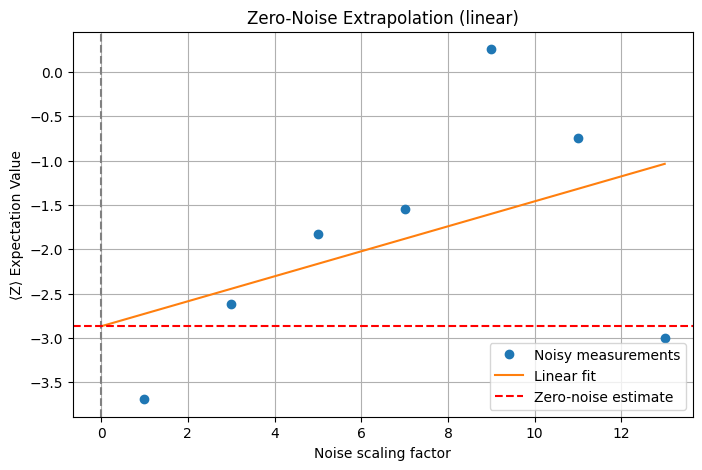


 Extrapolation Method: QUADRATIC
⟨Z⟩ (ZNE Estimate): -5.086


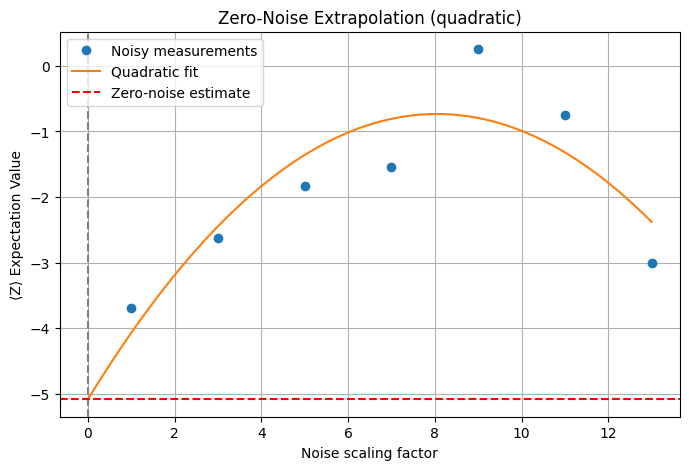


 Extrapolation Method: EXPONENTIAL
⟨Z⟩ (ZNE Estimate): -5.142


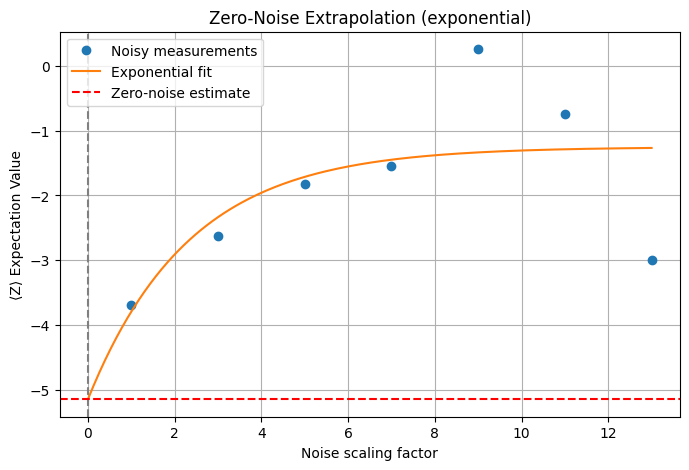

In [203]:
methods = ["linear", "quadratic", "exponential"]

for method in methods:
    print(f"\n Extrapolation Method: {method.upper()}")

    # Perform the extrapolation
    zero_val, fitted_vals, fit_params, fit_fn = zne_method(method=method, xdata=xdata, ydata=ydata)

    # Print the extrapolated expectation value
    print(f"⟨Z⟩ (ZNE Estimate): {zero_val:.3f}")

    # Plot the results
    plot_zne(xdata, fitted_vals, zero_val, fit_fn, fit_params, method)


In [204]:
# Check your submission status with the code below
from qc_grader.grader.grade import check_lab_completion_status

check_lab_completion_status("qgss_2025")

Lab 0: 0/2 exercises completed (0%)
    ✅ 1785 participants have completed this lab
Lab 1: 9/9 exercises completed (100%)
    ✅ 1064 participants have completed this lab
Lab 2: 7/7 exercises completed (100%)
    ✅ 295 participants have completed this lab
Lab 3: 0/5 exercises completed (0%)
    ✅ 0 participants have completed this lab
Lab 4: 0/6 exercises completed (0%)
    ✅ 0 participants have completed this lab
